In [2]:
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
import numpy as np
import gpflow
from matplotlib import pyplot as plt


def generate_sample(
    n_points: int = 500,
    sigma_n: float = 0.5,
    heteroskedastic: bool = False,
    percent_output_outliers: float = 0.0,
    add_input_outliers: bool = False,
    n_input_outliers: int = 10,
    input_outlier_spread: float = 20.0,
    seed: int = 10,
    plot: bool = True
) -> tuple[np.ndarray, np.ndarray, np.ndarray, gpflow.kernels.Kernel]:
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Kernel
    kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)

    # Original input and function
    x = np.linspace(0, 20, n_points).reshape(-1, 1)
    f = np.random.multivariate_normal(
        mean=np.zeros(n_points),
        cov=kernel(x, x) + 1e-8 * np.eye(n_points)
    ).reshape(-1, 1)

    # Noise: homoskedastic or heteroskedastic
    if heteroskedastic:
        # Example: noise increases linearly with x
        noise_scale = sigma_n * (1 + 0.1 * x.squeeze())
    else:
        noise_scale = sigma_n * np.ones(n_points)

    # ✅ Correct call: draw elementwise noise
    y_obs = f.squeeze() + np.random.normal(loc=0.0, scale=noise_scale)
    y_obs = y_obs.reshape(-1, 1)

    # Apply output outliers
    if percent_output_outliers > 0:
        i_mis = np.random.choice(n_points, int(percent_output_outliers * n_points), replace=False)
        factor = 5.0  # max absolute change
        y_obs[i_mis] += np.random.uniform(-factor, factor, size=(i_mis.size, 1))

    # Apply input outliers
    x_obs = x.copy()
    if add_input_outliers and n_input_outliers > 0:
        replace_idx = np.random.choice(n_points, n_input_outliers, replace=False)
        x_min, x_max = x.min(), x.max()

        x_outliers_low = np.random.uniform(
            low=x_min - input_outlier_spread,
            high=x_min - 0.1 * input_outlier_spread,
            size=(n_input_outliers // 2, 1)
        )
        x_outliers_high = np.random.uniform(
            low=x_max + 0.1 * input_outlier_spread,
            high=x_max + input_outlier_spread,
            size=(n_input_outliers - x_outliers_low.shape[0], 1)
        )
        x_outliers = np.vstack([x_outliers_low, x_outliers_high])
        x_obs[replace_idx] = x_outliers

    # Optional plotting
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(x, f, 'k--', lw=2, label='true f(x)')
        plt.plot(x_obs, y_obs, 'r.', ms=8, alpha=0.7, label='observed data')
        plt.legend()
        x_min_plot = x.min() - (input_outlier_spread if add_input_outliers else 0)
        x_max_plot = x.max() + (input_outlier_spread if add_input_outliers else 0)
        plt.xlim(x_min_plot, x_max_plot)
        title = "Generated GP Sample"
        if heteroskedastic:
            title += " (Heteroskedastic Noise)"
        else:
            title += " (Homoskedastic Noise)"
        plt.title(title)
        plt.show()

    return x_obs, y_obs, f, kernel


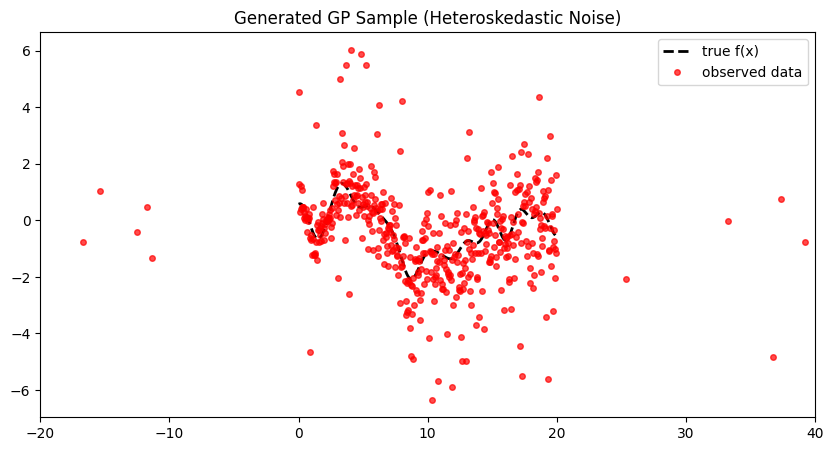

(array([[  0.        ],
        [  0.04008016],
        [-15.34853051],
        [  0.12024048],
        [  0.16032064],
        [  0.2004008 ],
        [  0.24048096],
        [  0.28056112],
        [  0.32064128],
        [  0.36072144],
        [  0.4008016 ],
        [  0.44088176],
        [  0.48096192],
        [  0.52104208],
        [  0.56112224],
        [  0.6012024 ],
        [  0.64128257],
        [  0.68136273],
        [  0.72144289],
        [  0.76152305],
        [  0.80160321],
        [  0.84168337],
        [  0.88176353],
        [  0.92184369],
        [  0.96192385],
        [  1.00200401],
        [  1.04208417],
        [  1.08216433],
        [  1.12224449],
        [  1.16232465],
        [  1.20240481],
        [  1.24248497],
        [  1.28256513],
        [  1.32264529],
        [  1.36272545],
        [  1.40280561],
        [  1.44288577],
        [  1.48296593],
        [  1.52304609],
        [  1.56312625],
        [  1.60320641],
        [  1.643

In [3]:
generate_sample(500,0.5,True,0.1,True)

We first do with no outliers

In [9]:
a[0]

array([[ 0.        ],
       [ 0.04008016],
       [ 0.08016032],
       [ 0.12024048],
       [ 0.16032064],
       [ 0.2004008 ],
       [ 0.24048096],
       [ 0.28056112],
       [ 0.32064128],
       [ 0.36072144],
       [ 0.4008016 ],
       [ 0.44088176],
       [ 0.48096192],
       [ 0.52104208],
       [ 0.56112224],
       [ 0.6012024 ],
       [ 0.64128257],
       [ 0.68136273],
       [ 0.72144289],
       [ 0.76152305],
       [ 0.80160321],
       [ 0.84168337],
       [ 0.88176353],
       [ 0.92184369],
       [ 0.96192385],
       [ 1.00200401],
       [ 1.04208417],
       [ 1.08216433],
       [ 1.12224449],
       [ 1.16232465],
       [ 1.20240481],
       [ 1.24248497],
       [ 1.28256513],
       [ 1.32264529],
       [ 1.36272545],
       [ 1.40280561],
       [ 1.44288577],
       [ 1.48296593],
       [ 1.52304609],
       [ 1.56312625],
       [ 1.60320641],
       [ 1.64328657],
       [ 1.68336673],
       [ 1.72344689],
       [ 1.76352705],
       [ 1

In [5]:
# --- SGPR: compute in-sample predictive mean/var from mu_u, Sigma_u ---
def _sgpr_insample_mu_var(model, X):
    """
    Returns numpy arrays (mu, var) at X for your GVI_SGPR_alpha.
    Uses: kernel = ExponentiatedQuadratic(model.variance, model.lengthscale)
    var(x) = k_xx - K_xu K_uu^{-1} K_ux + K_xu K_uu^{-1} Sigma_u K_uu^{-1} K_ux
    """
    import tensorflow_probability as tfp
    k = tfp.math.psd_kernels.ExponentiatedQuadratic(model.variance, model.lengthscale)

    X = tf.convert_to_tensor(X, dtype=tf.float64)
    Z = tf.convert_to_tensor(model.inducing_variable, dtype=tf.float64)
    N_u = int(model.N_u)

    K_uu = k.matrix(Z, Z)
    I_M = tf.eye(N_u, dtype=tf.float64)
    K_uu_inv = model.stable_solve(K_uu, I_M)

    K_xu = k.matrix(X, Z)
    K_ux = tf.transpose(K_xu)
    K_xx = k.matrix(X, X)

    # Sigma_u from structure
    if model.structure == "Diag":
        Sigma_u = tf.linalg.diag(tf.convert_to_tensor(model.Var_q, dtype=tf.float64))
    else:
        L = tf.convert_to_tensor(model.Var_q, dtype=tf.float64)
        Sigma_u = L @ tf.transpose(L)

    # mean & variance
    mu = K_xu @ K_uu_inv @ tf.convert_to_tensor(model.mu_u, dtype=tf.float64)
    A = K_xu @ K_uu_inv
    var = tf.linalg.diag_part(K_xx - A @ K_ux + A @ Sigma_u @ tf.transpose(A))

    mu = tf.squeeze(mu).numpy()
    var = tf.squeeze(var).numpy()
    return mu, var

def eval_and_store_sgpr(model, name, perc, input_o, seed, x, f, results):
    """
    Calls model.predict_ins(), then computes μ, Var in-sample and stores MSE & 95% coverage.
    """
    try:
        model.predict_ins()
    except Exception as e:
        print(f"predict_ins() failed for {name} (seed {seed}, perc {perc}, input_o {input_o}): {e}")
        results.append({
            'case_perc': perc,
            'case_input_outliers': bool(input_o),
            'seed': int(seed),
            'model': name,
            'mse': np.nan,
            'coverage': np.nan,
            'error': True,
            'error_message': f"predict_ins error: {e}"
        })
        return

    try:
        mu, var = _sgpr_insample_mu_var(model, x)
    except Exception as e:
        print(f"[ERROR] SGPR in-sample μ/Var failed for {name}: {e}")
        results.append({
            'case_perc': perc,
            'case_input_outliers': bool(input_o),
            'seed': int(seed),
            'model': name,
            'mse': np.nan,
            'coverage': np.nan,
            'error': True,
            'error_message': f"sgpr mu/var error: {e}"
        })
        return

    eval_and_store_from_mu_var(mu, var, name, perc, input_o, seed, f, results)
    
    

    
import traceback
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow
from models import GVI_GP_alpha,GVI_SGPR_alpha,GVI_GP_FI_alpha

# --- Evaluation & storage (consistent schema) ---
def eval_and_store_from_mu_var(mu_arr, var_arr, name, perc, input_o, seed, f, results, hetero):
    """
    Given numpy arrays mu_arr (N,) and var_arr (N,) compute MSE vs f and 95% coverage, append to results.
    """
    mu = np.asarray(mu_arr).reshape(-1)
    var = np.asarray(var_arr).reshape(-1)
    var = np.maximum(var, 0.0)
    std_p = 1.96 * np.sqrt(var)
    upper = mu + std_p
    lower = mu - std_p
    f_arr = np.asarray(f).reshape(-1)
    mse = float(np.mean((mu - f_arr) ** 2))
    coverage = float(np.mean((f_arr >= lower) & (f_arr <= upper)))
    results.append({
        'case_perc': perc,
        'case_input_outliers': bool(input_o),
        'case_heteroskedastic': hetero,   # ✅ include heteroskedastic flag
        'seed': int(seed),
        'model': name,
        'mse': mse,
        'coverage': coverage,
        'error': False,
        'error_message': ""
    })

def eval_and_store(model, name, perc, input_o, seed, x, f, results, hetero):
    """
    Existing model interface: calls model.predict_ins() then reads model.mu_f and model.Sigma_f.
    Keeps backwards compatibility with your GVI models.
    """
    try:
        model.predict_ins()
    except Exception as e:
        print(f"predict_ins() failed for {name} (seed {seed}, perc {perc}, input_o {input_o}): {e}")
        results.append({
            'case_perc': perc,
            'case_input_outliers': bool(input_o),
            'case_heteroskedastic': hetero,   # ✅ add here
            'seed': int(seed),
            'model': name,
            'mse': np.nan,
            'coverage': np.nan,
            'error': True,
            'error_message': f"predict_ins error: {e}"
        })
        return

    # predictive mean
    try:
        mu = np.asarray(tf.squeeze(model.mu_f)).reshape(-1)
    except Exception:
        mu = np.asarray(model.mu_f).reshape(-1)

    # predictive variance
    try:
        Sigma = model.Sigma_f
        try:
            var = np.asarray(tf.linalg.diag_part(Sigma)).reshape(-1)
        except Exception:
            var = np.asarray(Sigma).reshape(-1)
    except Exception:
        try:
            var = np.asarray(model.Sigma_f).reshape(-1)
        except Exception:
            var = np.zeros_like(mu)

    eval_and_store_from_mu_var(mu, var, name, perc, input_o, seed, f, results, hetero)


# --- safe_fit diagnostics wrapper ---
def safe_fit(model_obj, fit_fn, name, perc, input_o, seed, results, hetero):
    """
    fit_fn: callable with no args that runs the fitting.
    """
    print(f"[FITTING] case_perc={perc}, input_o={input_o}, seed={seed}, model={name}", flush=True)
    try:
        fit_fn()
        print(f"[OK] finished {name}", flush=True)
        return True
    except Exception as e:
        print(f"\n[ERROR] fit failed for {name}: {e}", flush=True)
        # record failed run
        results.append({
            'case_perc': perc,
            'case_input_outliers': bool(input_o),
            'case_heteroskedastic': hetero,   # ✅ add here
            'seed': int(seed),
            'model': name,
            'mse': np.nan,
            'coverage': np.nan,
            'error': True,
            'error_message': str(e)
        })
        return False


# --- All create_fit_eval / SGPR / FI helpers ---
def create_fit_eval(name, x, y_obs, base_kernel, perc, input_o, seed, f, results, hetero, fit_method="internal_opt", **model_kwargs):
    try:
        model = GVI_GP_alpha(x, y_obs, base_kernel, **model_kwargs)
    except Exception as e:
        results.append({
            'case_perc': perc,
            'case_input_outliers': bool(input_o),
            'case_heteroskedastic': hetero,
            'seed': int(seed),
            'model': name,
            'mse': np.nan,
            'coverage': np.nan,
            'error': True,
            'error_message': f"construction error: {e}"
        })
        return

    if fit_method == "internal_opt":
        ok = safe_fit(model, model.internal_opt, name, perc, input_o, seed, results, hetero)
    else:
        ok = safe_fit(model, model.pp_alg, name, perc, input_o, seed, results, hetero)

    if ok:
        eval_and_store(model, name, perc, input_o, seed, x, f, results, hetero)


def create_fit_eval_sgpr(name, x, y_obs, inducing, N_u, perc, input_o, seed, f, results,
                         fit_method="internal_opt", loss_type="MSE",
                         structure="Diag", alpha=0.5, test_size=0.1,hetero=False):
    """
    For class GVI_SGPR_alpha: builds, fits (internal_opt or pp_alg), then evaluates in-sample.
    hetero: bool, whether to generate/fit with heteroskedastic noise
    """
    try:
        model = GVI_SGPR_alpha(
            X=x,
            y=y_obs,
            inducing=inducing,
            N_u=N_u,
            loss_type=loss_type,
            structure=structure,
            alpha=alpha,
            test_size=test_size  # pass the hetero flag to the model
        )
    except Exception as e:
        print(f"[ERROR] constructing SGPR {name} failed: {e}")
        results.append({
            'case_perc': perc,
            'case_input_outliers': bool(input_o),
            'case_heteroskedastic': hetero,
            'seed': int(seed),
            'model': name,
            'mse': np.nan,
            'coverage': np.nan,
            'error': True,
            'error_message': f"construction error: {e}"
        })
        return

    # choose fit method and run
    if fit_method == "internal_opt":
        ok = safe_fit(model, model.internal_opt, name, perc, input_o, seed, results,hetero=hetero)
    else:
        ok = safe_fit(model, model.pp_alg, name, perc, input_o, seed, results,hetero=hetero)

    if ok:
        eval_and_store_sgpr(model, name, perc, input_o, seed, x, f, results)
def create_and_eval_gpr(name, x, y_obs, base_kernel, perc, input_o, seed, f, results, hetero=False):
    """
    Standard exact GP regression for comparison baseline.
    hetero: bool, for storing in results and passing to safe_fit
    """
    try:
        gpr = gpflow.models.GPR(
            data=(x, y_obs),
            kernel=base_kernel,
            mean_function=None
        )
        opt = gpflow.optimizers.Scipy()
        fit_fn = lambda: opt.minimize(gpr.training_loss, gpr.trainable_variables)

        # 🔑 pass hetero to safe_fit
        ok = safe_fit(gpr, fit_fn, name, perc, input_o, seed, results, hetero=hetero)
        if not ok:
            return

        # evaluate
        y_pred, var_pred = gpr.predict_f(x)
        mse = np.mean((y_pred.numpy() - f) ** 2)
        coverage = np.nan  # or compute coverage if desired

        results.append({
            'case_perc': perc,
            'case_input_outliers': bool(input_o),
            'case_heteroskedastic': hetero,
            'seed': int(seed),
            'model': name,
            'mse': mse,
            'coverage': coverage,
            'error': False,
            'error_message': ""
        })
    except Exception as e:
        results.append({
            'case_perc': perc,
            'case_input_outliers': bool(input_o),
            'case_heteroskedastic': hetero,
            'seed': int(seed),
            'model': name,
            'mse': np.nan,
            'coverage': np.nan,
            'error': True,
            'error_message': f"GPR construction/fitting error: {e}"
        })



def create_fit_eval_fi(name, x, y_obs, inducing, perc, input_o, seed, f, results, hetero,
                       fit_method="internal_opt", **kwargs):
    try:
        model = GVI_GP_FI_alpha(X=x, y=y_obs, inducing=inducing, **kwargs)
    except Exception as e:
        results.append({
            'case_perc': perc, 'case_input_outliers': bool(input_o), 'case_heteroskedastic': hetero,
            'seed': int(seed),
            'model': name, 'mse': np.nan, 'coverage': np.nan, 'error': True,
            'error_message': f"construction error: {e}"
        })
        return

    if fit_method == "internal_opt":
        ok = safe_fit(model, model.internal_opt, name, perc, input_o, seed, results, hetero)
    else:
        ok = safe_fit(model, model.internal_opt, name, perc, input_o, seed, results, hetero)

    if ok:
        eval_and_store(model, name, perc, input_o, seed, x, f, results, hetero)

import copy

# --- Main loops ---
cases = [
    [0.0, False, False],   # clean, homoskedastic
    [0.1, False, False],   # output outliers only
    [0.0, True,  False],   # input outliers only
    [0.1, True,  False],   # both types of outliers
    [0.0, False, True]     # NEW: heteroskedastic, no outliers
]
seeds = [1,2,3,4,5,6]
N = 50
results = []
# --- Main loops ---
for perc, input_o, hetero in cases:
    for seed in seeds:
        # generate data
        x, y_obs, f, kernel_from_data = generate_sample(
            seed=seed, plot=False,
            add_input_outliers=input_o,
            percent_output_outliers=perc,
            heteroskedastic=hetero,
            n_points=400
        )

        # inducing points
        Z = np.linspace(np.min(x), np.max(x), 50)[:, None]
        inducing_variable = gpflow.Parameter(Z, trainable=False)

        # master kernel
        base_kernel_master = gpflow.kernels.SquaredExponential(
            lengthscales=0.1,
            variance=0.1
        )

        # ✅ Pass hetero=hetero in all calls
        create_fit_eval('predictive_c_f_MSE_calibrated',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="predictive", inducing=inducing_variable,
                        Sigma_f_structure="c_f", loss_type="MSE")

        create_fit_eval('predictive_inducing_MSE',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="predictive", inducing=inducing_variable,
                        Sigma_f_structure="inducing", loss_type="MSE")

        create_fit_eval('GVI_inducing_MSE_ppalg',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="pp_alg",
                        objective="GVI", inducing=inducing_variable,
                        Sigma_f_structure="inducing", loss_type="MSE")

        create_fit_eval('GVI_inducing_likelihood_ppalg',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="pp_alg",
                        objective="GVI", inducing=inducing_variable,
                        Sigma_f_structure="inducing", loss_type="likelihood")

        create_fit_eval('predictive_c_f_MSE',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="predictive", inducing=inducing_variable,
                        Sigma_f_structure="c_f", loss_type="MSE")

        create_fit_eval('predictive_c_f_likelihood_calibrated',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="predictive", inducing=inducing_variable,
                        Sigma_f_structure="c_f", loss_type="likelihood")

        create_fit_eval('predictive_inducing_likelihood_ppalg_2',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="pp_alg",
                        objective="GVI", inducing=inducing_variable,
                        Sigma_f_structure="inducing", loss_type="likelihood")

        create_fit_eval('predictive_inducing_likelihood',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="predictive", inducing=inducing_variable,
                        Sigma_f_structure="inducing", loss_type="likelihood")

        create_fit_eval('predictive_c_f_likelihood',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="predictive", inducing=inducing_variable,
                        Sigma_f_structure="c_f", loss_type="likelihood")

        create_fit_eval('GVI_inducing_likelihood',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="GVI", inducing=inducing_variable,
                        Sigma_f_structure="inducing", loss_type="likelihood")

        create_fit_eval('GVI_c_f_likelihood',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="GVI", inducing=inducing_variable,
                        Sigma_f_structure="c_f", loss_type="likelihood")

        create_fit_eval('GVI_c_f_calibrating_likelihood',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="GVI", inducing=inducing_variable,
                        c_f_calibrating=True,
                        Sigma_f_structure="c_f", loss_type="likelihood")

        create_fit_eval('GVI_inducing_MSE',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="GVI", inducing=inducing_variable,
                        Sigma_f_structure="inducing", loss_type="MSE")

        create_fit_eval('GVI_c_f_MSE',
                        x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
                        perc=perc, input_o=input_o, seed=seed, f=f, results=results,
                        hetero=hetero,
                        fit_method="internal_opt",
                        objective="GVI", inducing=inducing_variable,
                        Sigma_f_structure="c_f", loss_type="MSE")

        # --- SGPR, FI etc. don’t take a base_kernel directly ---
        create_fit_eval_sgpr(
            'GVI_SGPR_alpha_tri',
            x=x, y_obs=y_obs,
            inducing=inducing_variable,
            N_u=inducing_variable.shape[0],
            perc=perc, input_o=input_o, seed=seed, f=f, results=results,
            fit_method="internal_opt",
            loss_type="likelihood",
            structure="Tri",
            alpha=0.5,
            test_size=0.1
        )

        create_fit_eval_fi(
            'GVI_GP_FI_alpha',
            x=x, y_obs=y_obs,
            inducing=inducing_variable,
            perc=perc, input_o=input_o, seed=seed, f=f, results=results,
            hetero=hetero,
            fit_method="internal_opt",
            alpha=0.5, lengthscale=1.0, variance=1.0
        )

        create_fit_eval(
            'variational_diag_MSE',
            x=x, y_obs=y_obs, base_kernel=copy.deepcopy(base_kernel_master),
            perc=perc, input_o=input_o, seed=seed, f=f, results=results,
            hetero=hetero,
            fit_method="internal_opt",
            objective="variational",
            inducing=inducing_variable,
            Sigma_f_structure="Diag",
            loss_type="MSE"
        )

        # --- Standard exact GPR (comparison baseline) ---
        create_and_eval_gpr(
            'GPR_exact',
            x, y_obs, copy.deepcopy(base_kernel_master),
            perc, input_o, seed, f, results,hetero=hetero
        )


# --- After loops: assemble results and show summary ---
df = pd.DataFrame(results)
print("\nRaw results rows:", len(df))
print("Columns in results:", df.columns.tolist())

# Ensure expected columns exist
expected_cols = ['case_perc', 'case_input_outliers', 'seed', 'model', 'mse', 'coverage', 'error', 'error_message']
for c in expected_cols:
    if c not in df.columns:
        df[c] = np.nan

# Convert types when sensible
df['case_input_outliers'] = df['case_input_outliers'].astype(bool, errors='ignore')
df['seed'] = pd.to_numeric(df['seed'], errors='coerce')

# Exclude failed runs for numeric summary
numeric_df = df[df['error'].fillna(False) == False].copy()

if numeric_df.shape[0] == 0:
    print("No successful runs to summarize (all failed). Showing raw results instead:")
    print(df.to_string())
else:
    summary = numeric_df.groupby(['case_perc', 'case_input_outliers', 'model']).agg(
        mse_mean=('mse', 'mean'),
        mse_std=('mse', 'std'),
        coverage_mean=('coverage', 'mean'),
        coverage_std=('coverage', 'std'),
        n=('mse', 'count')
    ).reset_index()

    pd.set_option('display.float_format', lambda x: f"{x:.4f}")
    print("\nSUMMARY (successful runs):")
    print(summary.sort_values(['case_perc', 'case_input_outliers', 'model']).to_string(index=False))

# Print failed runs (if any)
failures = df[df['error'].fillna(False) == True]
if len(failures):
    print("\nFAILED RUNS SUMMARY:")
    print(failures[['case_perc', 'case_input_outliers', 'seed', 'model', 'error_message']].to_string(index=False))

[FITTING] case_perc=0.0, input_o=False, seed=1, model=predictive_c_f_MSE_calibrated
[OK] finished predictive_c_f_MSE_calibrated
[FITTING] case_perc=0.0, input_o=False, seed=1, model=predictive_inducing_MSE
[OK] finished predictive_inducing_MSE
[FITTING] case_perc=0.0, input_o=False, seed=1, model=GVI_inducing_MSE_ppalg
[OK] finished GVI_inducing_MSE_ppalg
[FITTING] case_perc=0.0, input_o=False, seed=1, model=GVI_inducing_likelihood_ppalg
[OK] finished GVI_inducing_likelihood_ppalg
[FITTING] case_perc=0.0, input_o=False, seed=1, model=predictive_c_f_MSE
[OK] finished predictive_c_f_MSE
[FITTING] case_perc=0.0, input_o=False, seed=1, model=predictive_c_f_likelihood_calibrated
[OK] finished predictive_c_f_likelihood_calibrated
[FITTING] case_perc=0.0, input_o=False, seed=1, model=predictive_inducing_likelihood_ppalg_2
[OK] finished predictive_inducing_likelihood_ppalg_2
[FITTING] case_perc=0.0, input_o=False, seed=1, model=predictive_inducing_likelihood
[OK] finished predictive_inducing_l

TypeError: eval_and_store_from_mu_var() missing 1 required positional argument: 'hetero'

In [16]:
failures

,case_perc,case_input_outliers,case_heteroskedastic,seed,model,mse,coverage,error,error_message
14,0.0000,False,False,1,GVI_SGPR_alpha_tri,NaN,NaN,True,construction error: GVI_SGPR_alpha.__init__() ...
19,0.0000,False,False,2,predictive_inducing_MSE,NaN,NaN,True,Graph execution error:\n\nDetected at node Mat...
32,0.0000,False,False,2,GVI_SGPR_alpha_tri,NaN,NaN,True,construction error: GVI_SGPR_alpha.__init__() ...
34,0.0000,False,False,2,variational_diag_MSE,NaN,NaN,True,Graph execution error:\n\nDetected at node Mat...
50,0.0000,False,False,3,GVI_SGPR_alpha_tri,NaN,NaN,True,construction error: GVI_SGPR_alpha.__init__() ...
51,0.0000,False,False,3,GVI_GP_FI_alpha,NaN,NaN,True,Graph execution error:\n\nDetected at node Ver...
68,0.0000,False,False,4,GVI_SGPR_alpha_tri,NaN,NaN,True,construction error: GVI_SGPR_alpha.__init__() ...
86,0.0000,False,False,5,GVI_SGPR_alpha_tri,NaN,NaN,True,construction error: GVI_SGPR_alpha.__init__() ...
104,0.0000,False,False,6,GVI_SGPR_alpha_tri,NaN,NaN,True,construction error: GVI_SGPR_alpha.__init__() ...
122,0.1000,False,False,1,GVI_SGPR_alpha_tri,NaN,NaN,True,construction error: GVI_SGPR_alpha.__init__() ...


In [17]:
summary

,case_perc,case_input_outliers,model,mse_mean,mse_std,coverage_mean,coverage_std,n
0,0.0000,False,GPR_exact,0.0267,0.0201,NaN,NaN,12
1,0.0000,False,GVI_GP_FI_alpha,0.6712,0.4164,0.3252,0.1219,11
2,0.0000,False,GVI_c_f_MSE,0.0273,0.0139,0.9752,0.0311,12
3,0.0000,False,GVI_c_f_calibrating_likelihood,0.0269,0.0211,0.9800,0.0280,12
4,0.0000,False,GVI_c_f_likelihood,0.0246,0.0159,0.9646,0.0279,12
...,...,...,...,...,...,...,...,...
63,0.1000,True,predictive_c_f_likelihood_calibrated,0.1549,0.0776,0.0810,0.0323,5
64,0.1000,True,predictive_inducing_MSE,0.4491,0.6114,0.0408,0.0682,6
65,0.1000,True,predictive_inducing_likelihood,0.3620,0.4534,0.0425,0.0575,6
66,0.1000,True,predictive_inducing_likelihood_ppalg_2,0.0691,0.0189,0.9417,0.0427,6


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import openml
import copy

    
import traceback
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow
from models import GVI_GP_alpha,GVI_SGPR_alpha



def load_concrete_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    df = pd.read_excel(url)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y


def load_energy_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    df = pd.read_excel(url)
    X = df.iloc[:, :8].values
    y = df.iloc[:, 8].values  # Heating load
    return X, y


def load_yacht_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data"
    df = pd.read_csv(url, delim_whitespace=True, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

def load_kin8nm_dataset():
    dataset = openml.datasets.get_dataset(189)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    return X.values, y.values


def load_boston_dataset():
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)

    # Pair rows and unpack features and target
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]
    return X,y


def normalize_split(X, y, test_size=0.2, seed=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
    return X_train, X_test, y_train, y_test


# Dict of dataset loaders
dataset_loaders = {
    "concrete": load_concrete_dataset,
    "energy": load_energy_dataset,
    "yacht": load_yacht_dataset,
    "boston": load_boston_dataset
}

loss_st = []
loss_a = []
# Loop through all datasets<
# --- Loop through datasets ---
import numpy as np
import pandas as pd
import copy
import tensorflow as tf
import gpflow
from models import GVI_GP_alpha, GVI_SGPR_alpha

# --- Store results ---
results = []

for name, loader in dataset_loaders.items():
    try:
        X, y = loader()
        y = y.reshape(-1, 1)
        X_train, X_test, y_train, y_test = normalize_split(X, y)
        y_test = y_test.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)

        np.random.seed(0)
        num_inducing = min(100, X_train.shape[0])
        Z = X_train[np.random.choice(X_train.shape[0], num_inducing, replace=False), :]
        inducing_variable = gpflow.Parameter(Z, trainable=False)
        base_kernel_master = gpflow.kernels.SquaredExponential(lengthscales=0.1, variance=0.1)

        # --- Standard GP ---
        try:
            standard_gp = gpflow.models.GPR(
                (X_train, y_train),
                kernel=gpflow.kernels.SquaredExponential(lengthscales=1., variance=1.),
                noise_variance=1.
            )
            opt = gpflow.optimizers.Scipy()
            opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)
            f_mean, f_var = standard_gp.predict_f(X_test, full_cov=False)
            results.append({"dataset": name, "model": "standard_GP", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "standard_GP", "MSE": None, "error": str(e)})

        # --- GVI GP MSE ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="MSE",
                objective="GVI"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean = model.predict_out(X_test)
            results.append({"dataset": name, "model": "GVI_GP_MSE", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "GVI_GP_MSE", "MSE": None, "error": str(e)})

        # --- Predictive MSE ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="MSE",
                objective="predictive",
                lambda_method="predictive"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean = model.predict_out(X_test)
            results.append({"dataset": name, "model": "Predictive_MSE", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "Predictive_MSE", "MSE": None, "error": str(e)})

        # --- Predictive Likelihood ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="likelihood",
                objective="predictive"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean = model.predict_out(X_test)
            results.append({"dataset": name, "model": "Predictive_Likelihood", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "Predictive_Likelihood", "MSE": None, "error": str(e)})

        # --- GVI pp_alg ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="likelihood",
                objective="GVI"
            )
            model.pp_alg()
            model.predict_ins()
            f_mean = model.predict_out(X_test)
            results.append({"dataset": name, "model": "GVI_pp_alg", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "GVI_pp_alg", "MSE": None, "error": str(e)})

        # --- GVI inducing ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="likelihood",
                objective="GVI",
                Sigma_f_structure="inducing"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean = model.predict_out(X_test)
            results.append({"dataset": name, "model": "GVI_Likelihood_inducing", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "GVI_Likelihood_inducing", "MSE": None, "error": str(e)})

        # --- GVI SGPR ---
        try:
            model = GVI_SGPR_alpha(
                X_train, y_train,
                inducing_variable, 100,
                loss_type="likelihood",
                objective="GVI"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean = model.predict_out(X_test)
            results.append({"dataset": name, "model": "GVI_SGPR", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "GVI_SGPR", "MSE": None, "error": str(e)})

        # --- SVGP ---
        try:
            kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
            likelihood = gpflow.likelihoods.Gaussian(variance=1.0)
            svgp = gpflow.models.SVGP(
                kernel=kernel,
                likelihood=likelihood,
                inducing_variable=Z,
                num_latent_gps=1,
            )
            opt = gpflow.optimizers.Scipy()
            data = (X_train, y_train)
            training_loss = svgp.training_loss_closure(data)
            opt.minimize(training_loss, variables=svgp.trainable_variables)
            f_mean, f_var = svgp.predict_f(X_test, full_cov=False)
            results.append({"dataset": name, "model": "SVGP", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "SVGP", "MSE": None, "error": str(e)})

    except Exception as e:
        results.append({"dataset": name, "model": "LOADING_DATASET", "MSE": None, "error": str(e)})

# --- Save results to CSV ---
df_results = pd.DataFrame(results)
df_results


2025-08-20 00:00:17.452052: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-08-20 00:00:17.453114: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-08-20 00:00:17.657898: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-08-20 00:00:17.659114: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-08-20 00:00:17.912457: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular out

,dataset,model,MSE,error
0,concrete,standard_GP,0.110115,NaN
1,concrete,GVI_GP_MSE,0.180133,NaN
2,concrete,Predictive_MSE,0.110363,NaN
3,concrete,Predictive_Likelihood,0.113438,NaN
4,concrete,GVI_pp_alg,0.107843,NaN
5,concrete,GVI_Likelihood_inducing,NaN,Graph execution error:\n\nDetected at node Mat...
6,concrete,GVI_SGPR,0.147216,NaN
7,concrete,SVGP,0.122523,NaN
8,energy,standard_GP,0.003394,NaN
9,energy,GVI_GP_MSE,1.114957,NaN


In [10]:
df_results

,dataset,model,MSE,error
0,concrete,standard_GP,0.110115,NaN
1,concrete,GVI_GP_MSE,0.180133,NaN
2,concrete,Predictive_MSE,0.110363,NaN
3,concrete,Predictive_Likelihood,0.113438,NaN
4,concrete,GVI_pp_alg,0.107843,NaN
5,concrete,GVI_Likelihood_inducing,NaN,Graph execution error:\n\nDetected at node Mat...
6,concrete,GVI_SGPR,0.147216,NaN
7,concrete,SVGP,0.122523,NaN
8,energy,standard_GP,0.003394,NaN
9,energy,GVI_GP_MSE,1.114957,NaN


In [8]:
df_results["error"][30]

'in user code:\n\n    File "/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py", line 521, in train_step  *\n        loss = self.GVI_step()\n    File "/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py", line 361, in GVI_step  *\n        K_uu_inv = tf.linalg.inv(K_uu + jitter)\n\n    ValueError: Dimensions must be equal, but are 100 and 50 for \'{{node add}} = AddV2[T=DT_DOUBLE](ExponentiatedQuadratic_1/matrix/Exp, mul)\' with input shapes: [100,100], [50,50].\n'

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import openml
import copy

    
import traceback
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow
from models import GVI_GP_alpha,GVI_SGPR_alpha



def load_concrete_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    df = pd.read_excel(url)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y


def load_energy_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    df = pd.read_excel(url)
    X = df.iloc[:, :8].values
    y = df.iloc[:, 8].values  # Heating load
    return X, y


def load_yacht_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data"
    df = pd.read_csv(url, delim_whitespace=True, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

def load_kin8nm_dataset():
    dataset = openml.datasets.get_dataset(189)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    return X.values, y.values


def load_boston_dataset():
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)

    # Pair rows and unpack features and target
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]
    return X,y


def normalize_split(X, y, test_size=0.2, seed=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
    return X_train, X_test, y_train, y_test


# Dict of dataset loaders
dataset_loaders = {
    "concrete": load_concrete_dataset,
    "energy": load_energy_dataset,
    "yacht": load_yacht_dataset,
    "boston": load_boston_dataset
}

loss_st = []
loss_a = []
# Loop through all datasets<
# --- Loop through datasets ---
import numpy as np
import pandas as pd
import copy
import tensorflow as tf
import gpflow
from models import GVI_GP_alpha, GVI_SGPR_alpha

# --- Store results ---
results = []
seeds = [1]

for seed in seeds:
    for name, loader in dataset_loaders.items():
        try:
            X, y = loader()
            y = y.reshape(-1, 1)
            X_train, X_test, y_train, y_test = normalize_split(X, y, seed=seed)
            y_test = y_test.reshape(-1, 1)
            y_train = y_train.reshape(-1, 1)

            np.random.seed(seed)
            num_inducing = min(100, X_train.shape[0])
            Z = X_train[np.random.choice(X_train.shape[0], num_inducing, replace=False), :]
            inducing_variable = gpflow.Parameter(Z, trainable=False)
            base_kernel_master = gpflow.kernels.SquaredExponential(lengthscales=0.1, variance=0.1)

            # --- Standard GP ---
            try:
                standard_gp = gpflow.models.GPR(
                    (X_train, y_train),
                    kernel=gpflow.kernels.SquaredExponential(lengthscales=1., variance=1.),
                    noise_variance=1.
                )
                opt = gpflow.optimizers.Scipy()
                opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

                f_mean, f_var = standard_gp.predict_f(X_test, full_cov=False)
                std_p = 1.64 * tf.sqrt(f_var + standard_gp.noise_variance)
                upper = tf.squeeze(f_mean) + std_p
                lower = tf.squeeze(f_mean) - std_p
                coverage = tf.reduce_mean(tf.cast((y_test < upper) & (y_test > lower), tf.float32))

                results.append({
                    "dataset": name,
                    "model": "standard_GP",
                    "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2)),
                    "Coverage": float(coverage)
                })
            except Exception as e:
                results.append({"dataset": name, "model": "standard_GP", "MSE": None, "error": str(e)})

            # --- GVI GP MSE ---
            try:
                model = GVI_GP_alpha(
                    X_train, y_train,
                    Kernel=copy.deepcopy(base_kernel_master),
                    inducing=inducing_variable,
                    loss_type="MSE",
                    objective="GVI"
                )
                model.internal_opt()
                model.predict_ins()
                f_mean, f_var = model.predict_out(X_test)
                std_p = 1.64 * tf.sqrt(f_var)
                upper = tf.squeeze(f_mean) + std_p
                lower = tf.squeeze(f_mean) - std_p
                coverage = tf.reduce_mean(tf.cast((y_test < upper) & (y_test > lower), tf.float32))

                results.append({
                    "dataset": name,
                    "model": "GVI_GP_MSE",
                    "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2)),
                    "Coverage": float(coverage)
                })
            except Exception as e:
                results.append({"dataset": name, "model": "GVI_GP_MSE", "MSE": None, "error": str(e)})

            # --- Predictive MSE ---
            try:
                model = GVI_GP_alpha(
                    X_train, y_train,
                    Kernel=copy.deepcopy(base_kernel_master),
                    inducing=inducing_variable,
                    loss_type="MSE",
                    objective="predictive",
                    lambda_method="predictive"
                )
                model.internal_opt()
                model.predict_ins()
                f_mean, f_var = model.predict_out(X_test)
                std_p = 1.64 * tf.sqrt(f_var)
                upper = tf.squeeze(f_mean) + std_p
                lower = tf.squeeze(f_mean) - std_p
                coverage = tf.reduce_mean(tf.cast((y_test < upper) & (y_test > lower), tf.float32))

                results.append({
                    "dataset": name,
                    "model": "Predictive_MSE",
                    "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2)),
                    "Coverage": float(coverage)
                })
            except Exception as e:
                results.append({"dataset": name, "model": "Predictive_MSE", "MSE": None, "error": str(e)})

            # --- Predictive Likelihood ---
            try:
                model = GVI_GP_alpha(
                    X_train, y_train,
                    Kernel=copy.deepcopy(base_kernel_master),
                    inducing=inducing_variable,
                    loss_type="likelihood",
                    objective="predictive"
                )
                model.internal_opt()
                model.predict_ins()
                f_mean, f_var = model.predict_out(X_test)
                std_p = 1.64 * tf.sqrt(f_var + model.sigma**2)
                upper = tf.squeeze(f_mean) + std_p
                lower = tf.squeeze(f_mean) - std_p
                coverage = tf.reduce_mean(tf.cast((y_test < upper) & (y_test > lower), tf.float32))

                results.append({
                    "dataset": name,
                    "model": "Predictive_Likelihood",
                    "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2)),
                    "Coverage": float(coverage)
                })
            except Exception as e:
                results.append({"dataset": name, "model": "Predictive_Likelihood", "MSE": None, "error": str(e)})

            # --- GVI pp_alg ---
            try:
                model = GVI_GP_alpha(
                    X_train, y_train,
                    Kernel=copy.deepcopy(base_kernel_master),
                    inducing=inducing_variable,
                    loss_type="likelihood",
                    objective="GVI"
                )
                model.pp_alg()
                model.predict_ins()
                f_mean, f_var = model.predict_out(X_test)
                std_p = 1.64 * tf.sqrt(f_var + model.sigma**2)
                upper = tf.squeeze(f_mean) + std_p
                lower = tf.squeeze(f_mean) - std_p
                coverage = tf.reduce_mean(tf.cast((y_test < upper) & (y_test > lower), tf.float32))

                results.append({
                    "dataset": name,
                    "model": "GVI_pp_alg",
                    "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2)),
                    "Coverage": float(coverage)
                })
            except Exception as e:
                results.append({"dataset": name, "model": "GVI_pp_alg", "MSE": None, "error": str(e)})

            # --- GVI Likelihood inducing ---
            try:
                model = GVI_GP_alpha(
                    X_train, y_train,
                    Kernel=copy.deepcopy(base_kernel_master),
                    inducing=inducing_variable,
                    loss_type="likelihood",
                    objective="GVI",
                    Sigma_f_structure="inducing"
                )
                model.internal_opt()
                model.predict_ins()
                f_mean, f_var = model.predict_out(X_test)
                std_p = 1.64 * tf.sqrt(f_var + model.sigma**2)
                upper = tf.squeeze(f_mean) + std_p
                lower = tf.squeeze(f_mean) - std_p
                coverage = tf.reduce_mean(tf.cast((y_test < upper) & (y_test > lower), tf.float32))

                results.append({
                    "dataset": name,
                    "model": "GVI_Likelihood_inducing",
                    "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2)),
                    "Coverage": float(coverage)
                })
            except Exception as e:
                results.append({"dataset": name, "model": "GVI_Likelihood_inducing", "MSE": None, "error": str(e)})

            # --- GVI SGPR ---
            try:
                model = GVI_SGPR_alpha(
                    X_train, y_train,
                    inducing_variable, 100,
                    loss_type="likelihood",
                    objective="GVI"
                )
                model.internal_opt()
                model.predict_ins()
                f_mean, f_var = model.predict_out(X_test)
                std_p = 1.64 * tf.sqrt(f_var + model.sigma**2)
                upper = tf.squeeze(f_mean) + std_p
                lower = tf.squeeze(f_mean) - std_p
                coverage = tf.reduce_mean(tf.cast((y_test < upper) & (y_test > lower), tf.float32))

                results.append({
                    "dataset": name,
                    "model": "GVI_SGPR",
                    "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2)),
                    "Coverage": float(coverage)
                })
            except Exception as e:
                results.append({"dataset": name, "model": "GVI_SGPR", "MSE": None, "error": str(e)})

            # --- SVGP ---
            try:
                kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
                likelihood = gpflow.likelihoods.Gaussian(variance=1.0)
                svgp = gpflow.models.SVGP(
                    kernel=kernel,
                    likelihood=likelihood,
                    inducing_variable=Z,
                    num_latent_gps=1,
                )
                opt = gpflow.optimizers.Scipy()
                data = (X_train, y_train)
                training_loss = svgp.training_loss_closure(data)
                opt.minimize(training_loss, variables=svgp.trainable_variables)

                f_mean, f_var = svgp.predict_f(X_test, full_cov=False)
                std_p = 1.64 * tf.sqrt(f_var + svgp.likelihood.variance)
                upper = tf.squeeze(f_mean) + std_p
                lower = tf.squeeze(f_mean) - std_p
                coverage = tf.reduce_mean(tf.cast((y_test < upper) & (y_test > lower), tf.float32))

                results.append({
                    "dataset": name,
                    "model": "SVGP",
                    "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2)),
                    "Coverage": float(coverage)
                })
            except Exception as e:
                results.append({"dataset": name, "model": "SVGP", "MSE": None, "error": str(e)})

        except Exception as e:
            results.append({"dataset": name, "model": "LOADING_DATASET", "MSE": None, "error": str(e)})

# --- Save results to DataFrame ---
df_results = pd.DataFrame(results)


# Group by dataset and model, then average MSE and Coverage across seeds
df_avg = df_results.groupby(["dataset", "model"], as_index=False)[["MSE", "Coverage"]].mean()

# df_avg now has one row per dataset/model with averaged metrics
df_avg

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-08-22 20:01:17.301534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.
	 [[{{function_node __forward_train_step_204173}}{{node MatrixInverse_1}}]]
2025-08-22 20:01:33.074776: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-08-22 20:01:33.078588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.
	 [[{{function_node __forward_train_step_227926}}{{node MatrixInverse_2}}]]
/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_18505/922008821.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None)
2025-08-22 20:02:34.351590: W

,dataset,model,MSE,Coverage
0,boston,LOADING_DATASET,NaN,NaN
1,concrete,GVI_GP_MSE,0.213785,0.206711
2,concrete,GVI_Likelihood_inducing,0.252847,0.558252
3,concrete,GVI_SGPR,NaN,NaN
4,concrete,GVI_pp_alg,0.157435,0.290249
5,concrete,Predictive_Likelihood,0.146092,0.329626
6,concrete,Predictive_MSE,0.151589,0.034122
7,concrete,SVGP,0.154364,0.337779
8,concrete,standard_GP,NaN,NaN
9,energy,GVI_GP_MSE,1.003698,0.525974


In [2]:
df_avg

,dataset,model,MSE,Coverage
0,boston,LOADING_DATASET,NaN,NaN
1,concrete,GVI_GP_MSE,0.213785,0.206711
2,concrete,GVI_Likelihood_inducing,0.252847,0.558252
3,concrete,GVI_SGPR,NaN,NaN
4,concrete,GVI_pp_alg,0.157435,0.290249
5,concrete,Predictive_Likelihood,0.146092,0.329626
6,concrete,Predictive_MSE,0.151589,0.034122
7,concrete,SVGP,0.154364,0.337779
8,concrete,standard_GP,NaN,NaN
9,energy,GVI_GP_MSE,1.003698,0.525974


In [29]:
df_results

,dataset,model,MSE,error
0,concrete,standard_GP,0.110115,NaN
1,concrete,GVI_GP_MSE,0.180133,NaN
2,concrete,Predictive_MSE,0.110363,NaN
3,concrete,Predictive_Likelihood,0.113438,NaN
4,concrete,GVI_pp_alg,0.107842,NaN
5,concrete,GVI_Likelihood_inducing,NaN,"Graph execution error:\n\nDetected at node MatrixInverse defined at (most recent call last):\n File ""<frozen runpy>"", line 198, in _run_module_as_main\n\n File ""<frozen runpy>"", line 88, in _run_code\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel_launcher.py"", line 18, in <module>\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/traitlets/config/application.py"", line 1075, in launch_instance\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelapp.py"", line 739, in start\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/tornado/platform/asyncio.py"", line 205, in start\n\n File ""/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py"", line 640, in run_forever\n\n File ""/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py"", line 1992, in _run_once\n\n File ""/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py"", line 88, in _run\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py"", line 545, in dispatch_queue\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py"", line 534, in process_one\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py"", line 437, in dispatch_shell\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py"", line 362, in execute_request\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py"", line 778, in execute_request\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py"", line 449, in do_execute\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/zmqshell.py"", line 549, in run_cell\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3075, in run_cell\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3130, in _run_cell\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/async_helpers.py"", line 128, in _pseudo_sync_runner\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3334, in run_cell_async\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3517, in run_ast_nodes\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3577, in run_code\n\n File ""/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_19844/2002327193.py"", line 209, in <module>\n\n File ""/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py"", line 274, in internal_opt\n\n File ""/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py"", line 84, in train_step\n\n File ""/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py"", line 85, in train_step\n\n File ""/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py"", line 141, in GVI_step\n\nInput is not invertible.\n\t [[{{node MatrixInverse}}]] [Op:__inference

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import openml
import copy

    
import traceback
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow
from models import GVI_GP_alpha,GVI_SGPR_alpha



def load_concrete_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    df = pd.read_excel(url)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y


def load_energy_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    df = pd.read_excel(url)
    X = df.iloc[:, :8].values
    y = df.iloc[:, 8].values  # Heating load
    return X, y


def load_yacht_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data"
    df = pd.read_csv(url, delim_whitespace=True, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

def load_kin8nm_dataset():
    dataset = openml.datasets.get_dataset(189)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    return X.values, y.values

"""
def load_boston_dataset():
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)

    # Pair rows and unpack features and target
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]
    return X,y
"""
def load_boston_dataset():
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
    names_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names"
    
    # Define column names manually based on documentation
    columns = [
        'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
        'RM', 'AGE', 'DIS', 'RAD', 'TAX',
        'PTRATIO', 'B', 'LSTAT', 'MEDV'
    ]
    
    df = pd.read_csv(data_url, sep=r"\s+", names=columns)
    X = df.drop('MEDV', axis=1).values
    y = df['MEDV'].values
    return X, y

def normalize_split(X, y, test_size=0.2, seed=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
    return X_train, X_test, y_train, y_test


# Dict of dataset loaders
dataset_loaders = {
    "concrete": load_concrete_dataset,
    "energy": load_energy_dataset,
    "yacht": load_yacht_dataset,
    "boston": load_boston_dataset
}

loss_st = []
loss_a = []
# Loop through all datasets<
# --- Loop through datasets ---
import numpy as np
import pandas as pd
import copy
import tensorflow as tf
import gpflow
from models import GVI_GP_alpha, GVI_SGPR_alpha

# --- Store results ---
results = []

for name, loader in dataset_loaders.items():
    try:
        X, y = loader()
        y = y.reshape(-1, 1)
        X_train, X_test, y_train, y_test = normalize_split(X, y)
        y_test = y_test.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)

        np.random.seed(0)
        num_inducing = min(100, X_train.shape[0])
        Z = X_train[np.random.choice(X_train.shape[0], num_inducing, replace=False), :]
        inducing_variable = gpflow.Parameter(Z, trainable=False)
        base_kernel_master = gpflow.kernels.SquaredExponential(lengthscales=0.1, variance=0.1)

        # --- Standard GP ---
        try:
            standard_gp = gpflow.models.GPR(
                (X_train, y_train),
                kernel=gpflow.kernels.SquaredExponential(lengthscales=1., variance=1.),
                noise_variance=1.
            )
            opt = gpflow.optimizers.Scipy()
            opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)
            f_mean, f_var = standard_gp.predict_f(X_test, full_cov=False)
            results.append({"dataset": name, "model": "standard_GP", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "standard_GP", "MSE": None, "error": str(e)})

        # --- GVI GP MSE ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="MSE",
                objective="GVI"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean,f_var = model.predict_out(X_test)
            results.append({"dataset": name, "model": "GVI_GP_MSE", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "GVI_GP_MSE", "MSE": None, "error": str(e)})

        # --- Predictive MSE ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="MSE",
                objective="predictive",
                lambda_method="predictive"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean,f_var = model.predict_out(X_test)
            results.append({"dataset": name, "model": "Predictive_MSE", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "Predictive_MSE", "MSE": None, "error": str(e)})
            
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="MSE",
                objective="predictive"
            )
            model.pp_alg()
            model.predict_ins()
            f_mean,f_var = model.predict_out(X_test)
            results.append({"dataset": name, "model": "Predictive_MSE_alg", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "Predictive_MSE_alg", "MSE": None, "error": str(e)})

        # --- Predictive Likelihood ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="likelihood",
                objective="predictive"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean,f_var = model.predict_out(X_test)
            results.append({"dataset": name, "model": "Predictive_Likelihood", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "Predictive_Likelihood", "MSE": None, "error": str(e)})

        # --- GVI pp_alg ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="likelihood",
                objective="GVI"
            )
            model.pp_alg()
            model.predict_ins()
            f_mean ,f_var= model.predict_out(X_test)
            results.append({"dataset": name, "model": "GVI_pp_alg", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "GVI_pp_alg", "MSE": None, "error": str(e)})

        # --- GVI inducing ---
        try:
            model = GVI_GP_alpha(
                X_train, y_train,
                Kernel=copy.deepcopy(base_kernel_master),
                inducing=inducing_variable,
                loss_type="likelihood",
                objective="GVI",
                Sigma_f_structure="inducing"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean,f_var = model.predict_out(X_test)
            results.append({"dataset": name, "model": "GVI_Likelihood_inducing", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "GVI_Likelihood_inducing", "MSE": None, "error": str(e)})

        # --- GVI SGPR ---
        try:
            model = GVI_SGPR_alpha(
                X_train, y_train,
                inducing_variable, 100,
                loss_type="likelihood",
                objective="GVI"
            )
            model.internal_opt()
            model.predict_ins()
            f_mean,f_var = model.predict_out(X_test)
            results.append({"dataset": name, "model": "GVI_SGPR", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "GVI_SGPR", "MSE": None, "error": str(e)})

        # --- SVGP ---
        try:
            kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
            likelihood = gpflow.likelihoods.Gaussian(variance=1.0)
            svgp = gpflow.models.SVGP(
                kernel=kernel,
                likelihood=likelihood,
                inducing_variable=Z,
                num_latent_gps=1,
            )
            opt = gpflow.optimizers.Scipy()
            data = (X_train, y_train)
            training_loss = svgp.training_loss_closure(data)
            opt.minimize(training_loss, variables=svgp.trainable_variables)
            f_mean, f_var = svgp.predict_f(X_test, full_cov=False)
            results.append({"dataset": name, "model": "SVGP", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})
        except Exception as e:
            results.append({"dataset": name, "model": "SVGP", "MSE": None, "error": str(e)})

    except Exception as e:
        results.append({"dataset": name, "model": "LOADING_DATASET", "MSE": None, "error": str(e)})

# --- Save results to CSV ---
df_results = pd.DataFrame(results)
df_results



2025-08-22 23:06:18.390271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.
	 [[{{function_node __forward_train_step_649933}}{{node MatrixInverse_1}}]]
2025-08-22 23:08:02.233853: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-08-22 23:08:02.234767: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-08-22 23:08:02.445752: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-08-22 23:08:02.447296: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with err

2025-08-22 23:10:37.893148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.
	 [[{{function_node __forward_train_step_862500}}{{node MatrixInverse_1}}]]
/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_20958/330184212.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None)
2025-08-22 23:12:08.994921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.
	 [[{{function_node __forward_train_step_1067189}}{{node MatrixInverse}}]]
2025-08-22 23:12:49.457414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.
	 [[{{function_node __forward_train_step_1150879}}{{node MatrixInve

,dataset,model,MSE,error
0,concrete,standard_GP,0.110115,NaN
1,concrete,GVI_GP_MSE,0.180133,NaN
2,concrete,Predictive_MSE,0.113450,NaN
3,concrete,Predictive_MSE_alg,0.110312,NaN
4,concrete,Predictive_Likelihood,NaN,Graph execution error:\n\nDetected at node Mat...
5,concrete,GVI_pp_alg,0.107844,NaN
6,concrete,GVI_Likelihood_inducing,NaN,Graph execution error:\n\nDetected at node Mat...
7,concrete,GVI_SGPR,0.147216,NaN
8,concrete,SVGP,0.122523,NaN
9,energy,standard_GP,0.003394,NaN


In [30]:
df_results

,dataset,model,MSE,error
0,concrete,standard_GP,0.110115,NaN
1,concrete,GVI_GP_MSE,0.180133,NaN
2,concrete,Predictive_MSE,0.110363,NaN
3,concrete,Predictive_Likelihood,0.113438,NaN
4,concrete,GVI_pp_alg,0.107842,NaN
5,concrete,GVI_Likelihood_inducing,NaN,"Graph execution error:\n\nDetected at node MatrixInverse defined at (most recent call last):\n File ""<frozen runpy>"", line 198, in _run_module_as_main\n\n File ""<frozen runpy>"", line 88, in _run_code\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel_launcher.py"", line 18, in <module>\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/traitlets/config/application.py"", line 1075, in launch_instance\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelapp.py"", line 739, in start\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/tornado/platform/asyncio.py"", line 205, in start\n\n File ""/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py"", line 640, in run_forever\n\n File ""/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py"", line 1992, in _run_once\n\n File ""/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py"", line 88, in _run\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py"", line 545, in dispatch_queue\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py"", line 534, in process_one\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py"", line 437, in dispatch_shell\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py"", line 362, in execute_request\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py"", line 778, in execute_request\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py"", line 449, in do_execute\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/zmqshell.py"", line 549, in run_cell\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3075, in run_cell\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3130, in _run_cell\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/async_helpers.py"", line 128, in _pseudo_sync_runner\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3334, in run_cell_async\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3517, in run_ast_nodes\n\n File ""/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py"", line 3577, in run_code\n\n File ""/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_19844/2002327193.py"", line 209, in <module>\n\n File ""/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py"", line 274, in internal_opt\n\n File ""/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py"", line 84, in train_step\n\n File ""/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py"", line 85, in train_step\n\n File ""/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/models.py"", line 141, in GVI_step\n\nInput is not invertible.\n\t [[{{node MatrixInverse}}]] [Op:__inference

In [5]:
model = GVI_SGPR_alpha(
                X_train, y_train,
                inducing_variable, 100,
                loss_type="likelihood",
                objective="GVI"
            )
model.internal_opt()
model.predict_ins()
f_mean,f_var = model.predict_out(X_test)
results.append({"dataset": name, "model": "GVI_SGPR", "MSE": float(tf.reduce_mean((f_mean - y_test) ** 2))})

ValueError: too many values to unpack (expected 2)

In [17]:
X, y = load_energy_dataset()
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = normalize_split(X, y)
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

np.random.seed(0)
num_inducing = min(100, X_train.shape[0])
Z = X_train[np.random.choice(X_train.shape[0], num_inducing, replace=False), :]
inducing_variable = gpflow.Parameter(Z, trainable=False)
base_kernel_master = gpflow.kernels.SquaredExponential(lengthscales=0.1, variance=0.1)
# --- GVI pp_alg ---

model = GVI_GP_alpha(
    X_train, y_train,
    Kernel=copy.deepcopy(base_kernel_master),
    inducing=inducing_variable,
    loss_type="likelihood",
    objective="predictive",
)
model.internal_opt()
model.predict_ins()
f_mean ,f_var= model.predict_out(X_test)
float(tf.reduce_mean((f_mean - y_test) ** 2))




1.1149567062676469

In [19]:
model.kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,2.13953e-07
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,0.108878


In [22]:
standard_gp = gpflow.models.GPR(
                (X_train, y_train),
                kernel=gpflow.kernels.SquaredExponential(lengthscales=1., variance=1.),
                noise_variance=1.
            )
opt = gpflow.optimizers.Scipy()
opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -676.5449508747022
        x: [ 1.990e+01  1.871e+06 -6.558e+00]
      nit: 66
      jac: [-1.832e-03  3.047e-09  4.247e-02]
     nfev: 106
     njev: 106
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [23]:
standard_gp

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.87097e+06
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,19.9014
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00141858


In [26]:
f_mean, f_var = standard_gp.predict_f(X_test, full_cov=False)
float(tf.reduce_mean((f_mean - y_test) ** 2))


0.0033944782331251405

In [27]:
f_mean

<tf.Tensor: shape=(154, 1), dtype=float64, numpy=
array([[-0.70013398],
       [-1.19702228],
       [ 1.44302681],
       [-0.50718583],
       [ 1.09103846],
       [ 0.66373287],
       [ 0.63929041],
       [ 0.66315624],
       [ 0.67413239],
       [ 0.10904326],
       [-1.56556517],
       [ 2.05347529],
       [-1.06579048],
       [ 2.01270423],
       [ 2.00185153],
       [ 0.41162403],
       [-1.15335373],
       [ 0.61025829],
       [-0.7707404 ],
       [-0.98365757],
       [-0.94649972],
       [ 1.06488267],
       [-1.16146954],
       [ 1.67798818],
       [-1.60906769],
       [-0.7800232 ],
       [-0.93441559],
       [-0.83310803],
       [-1.13617846],
       [ 1.77162672],
       [-0.96051963],
       [-0.91379571],
       [ 1.97274821],
       [-0.90908183],
       [ 0.62866141],
       [ 1.45003894],
       [-0.76815053],
       [ 1.52959598],
       [-0.46210318],
       [-1.14948213],
       [-1.06332316],
       [ 1.72685722],
       [-0.74159563],
    

In [28]:
model

name,class,transform,prior,trainable,shape,dtype,value
GVI_GP_alpha.alpha,Parameter,Identity,,True,(),float64,0.48351747923404514
GVI_GP_alpha.sigma,Parameter,Softplus,,True,(),float64,1.05388
GVI_GP_alpha.kernel.variance,Parameter,Softplus,,True,(),float64,2.1395308725357438e-07
GVI_GP_alpha.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.10887797364752676
GVI_GP_alpha.inducing_variable,Parameter,Identity,,False,"(100, 8)",float64,"[[-0.6865229, 0.70000364, -0.57170105..."
GVI_GP_alpha.c_f,Parameter,Softplus,,True,(),float64,1.00216
